In [1]:
# package(s) related to time, space and id
import datetime

# Used for mathematical functions
import math
import platform
import time

import matplotlib.pyplot as plt

# Used for making the graph to visualize our problem
import networkx as nx

# package(s) for data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import itertools
import tqdm

import plotly.express as px
from plotly.subplots import make_subplots
# spatial libraries
import pyproj
import shapely.geometry

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
from simplekml import Kml, Style



#### define function

In [2]:
# Shallow water factor
def get_swf (T, h):
    r = h/T
    swf = 1/(1-np.exp(4*(1-max([r, 1.1]))))
    return swf

# Adjusted velocity 
def get_Vadj (Bs, Bc, V, T, h, Ls, swf):
   
    # get blockage factor
    Am = Bs * T
    Ac = Bc * h
    Blockage = Am / Ac
    r = h/T
    
    #get limit speed 1
    #Vlim1 = np.sqrt (9.81*Ls/2*np.pi)
    
    #get limit speed 
    #Vlim2 = 0.78 * (np.sqrt(h*9.81)) * ((1 - Blockage)**2.25)
    #if Blockage < 0.1:
        #Vlim = np.sqrt (9.81*Ls/2*np.pi)
    if 0.09<=Blockage<=0.3:
        Vlim = 0.78 * (np.sqrt(h*9.81)) * ((1 - Blockage)**2.25)
    else:
        Vlim = np.sqrt (9.81*h)
        #Vlim = np.sqrt (9.81*Ls/2*np.pi)
        #Vlim = (np.sqrt(8*h*9.81))* (np.cos((3.14+(np.cos(1- Blockage))**-1))/3)**1.5

    # get shallow speed     
    r = h/T
    Vsh = 1.18 * V * (swf**(-0.75 - Blockage))
    
    #get adjusted velocity
    if Vsh <= 0.9 * Vlim and Vsh < V:
        Vadj = Vsh
    if V < 0.9 * Vlim and V < Vsh:
        Vadj = V 
    else:
        Vadj =min([V, 0.9 * Vlim, Vsh ])
    return r, Vadj

# Return current speed 
def get_Ur (Bs, Bc, Vadj, T, h):
    Am = Bs * T
    Ac = Bc * h
    Blockage = Am / Ac
    
    # get Froude number
    Frh = Vadj / np.sqrt(h * 9.81)
    Ur = (Blockage * Vadj)/(1-(Blockage)-(Frh**2))
    
    return Ur

# Relative velocity
def get_Urel (Ur, Vadj, swf):  
    Unarrow = Ur + Vadj
    Ushallow = swf * Vadj
    Urel = max([Unarrow, Ushallow])
    
    return Urel, Unarrow, Ushallow


####Rf
def get_Rf (Bs, Urel, T, Ls):
    
    # get cf
    Re = (Urel*Ls)/ (10**(-6))
    cf = 0.053 /((np.log10(Re)-2)**2)
    
    Rf = 1.2 * 0.5 *(Urel**2) * cf * (Bs *Ls + 2 * Ls * T)
    return  Rf

#####Rp
def get_Rp(Bs, T):
    Rp = 0.5 *(Vadj**2) * 0.1 * (Bs * T)
    return Rp

### z
def get_z(Bs, Bc, T, h, Ls):
    Ac = Bc * h
    As = Bs * T
    Frh =  Vadj/ np.sqrt(h*9.81)
    
    if Ac/As <= 5.45*h + 0.56*As-17.68:  #wide or narrow
        z = (((Vadj + 0.067)**2)-(0.067**2))/(2*9.81)*(-0.00002*(Bc/Bs)**3 + 0.0062*(Bc/Bs)**2-0.007*(Bc/Bs)+0.9927)
        
    else:#very wide
        z = 1.36 * (Bs*Ls*T)/Ls**2 * Frh**2/ np.sqrt(1-Frh**2)
    return z

##### Rz
def get_Rz(Bs, Bc, T, h, Ls):
    Rz = 9.81 * z * 0 * (Bs * T)
    return Rz

####Rtot
def get_Rtot(Rp, Rf, Rz):
    
    Rtot =  Rp + Rf + Rz
    return Rtot

# Power estimation 
# BHP > DHP > EHP
# 1) Effective horse power Pe (Power needed to overcome the total drag)
def get_Pe ():
    Pe = Vadj * Rtot/0.55
    return Pe

# 2) Delivered horse power Pd (Power delivered to the propeller shaft)
def get_Pd ():
    Pd = Pe/0.91 
    return Pd

# 3) Brake horse power or Propulsion power Pb (Required motor power)
def get_Pb ():
    Pb = Pd/1.07
    return Pb

#### input value for Urel

In [3]:
# M8 motor vessel
h = np.linspace(4,10,25)  # water depth from 3 m to 10 m is a suitable range for the Ductch waterways 
h_more = np.linspace(4,10,25)
V_more = np.linspace(0,6,25)
Bs = [11.4]
Bc= [150] 
V = [3]
T = [2.7]
Ls = [110]

#### prepare input matrix for calculation

In [4]:
V_more = np.linspace(0,6,25)
V_more

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
       5.5 , 5.75, 6.  ])

In [5]:
h_more = np.linspace(4,10,25)
h_more

array([ 4.  ,  4.25,  4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,
        6.25,  6.5 ,  6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,
        8.5 ,  8.75,  9.  ,  9.25,  9.5 ,  9.75, 10.  ])

In [6]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product( h_more, Bs, Bc, V_more, T, Ls))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"h_more": item[0],"Bs": item[1], "Bc": item[2], "V_more": item[3], "T": item[4], "Ls": item[5]}
    rows.append(row)

# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.head(50)

,h_more,Bs,Bc,V_more,T,Ls
0,4.00,11.4,150,0.00,2.7,110
1,4.00,11.4,150,0.25,2.7,110
2,4.00,11.4,150,0.50,2.7,110
3,4.00,11.4,150,0.75,2.7,110
4,4.00,11.4,150,1.00,2.7,110
5,4.00,11.4,150,1.25,2.7,110
6,4.00,11.4,150,1.50,2.7,110
7,4.00,11.4,150,1.75,2.7,110
8,4.00,11.4,150,2.00,2.7,110
9,4.00,11.4,150,2.25,2.7,110


#### use the defined function and get output table

In [7]:
results = []

for i, row in tqdm.tqdm(work_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)
    h = row['h_more']
    Bs = row['Bs']
    Bc = row['Bc']
    V = row['V_more']
    T = row['T']
    Ls = row['Ls']

    swf =  get_swf (T, h)
    r, Vadj = get_Vadj(Bs, Bc, V, T, h, Ls, swf)
    Ur = get_Ur(Bs, Bc, V, T, h)
    Urel, Unarrow, Ushallow = get_Urel(Ur, Vadj, swf)
    Rf = get_Rf(Bs, Urel, T, Ls)
    Rp = get_Rp(Bs, T)
    z = get_z (Bs, Bc, T, h, Ls)
    Rz = get_Rz (Bs, Bc, T, h, Ls)
    Rtot = get_Rtot(Rp, Rf, Rz)
    Pe = get_Pe ()
    Pd = get_Pd ()
    Pb = get_Pb ()
 
        
    result = {}
    result.update(row)
    result['Vadj'] = Vadj
    result['Ur'] = Ur
    result['Urel'] = Urel
    result['Unarrow'] = Unarrow
    result['Ushallow'] = Ushallow
    result['Rf'] = Rf
    result['Rp'] = Rp
    result['z'] = z
    result['Rz'] = Rz
    result['Rtot']= Rtot
    result['Pe'] = Pe
    result['Pb'] = Pb
    result['Pd'] = Pd
  
    results.append(result)

plot_df = pd.DataFrame(results)

plot_df.head(50)

0it [00:00, ?it/s]C:\Users\30698\AppData\Local\Temp\ipykernel_15528\3751867787.py:69: RuntimeWarning: divide by zero encountered in log10
  cf = 0.053 /((np.log10(Re)-2)**2)
625it [00:00, 14340.48it/s]


,h_more,Bs,Bc,V_more,T,Ls,Vadj,Ur,Urel,Unarrow,Ushallow,Rf,Rp,z,Rz,Rtot,Pe,Pb,Pd
0,4.00,11.4,150.0,0.00,2.7,110.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,4.00,11.4,150.0,0.25,2.7,110.0,0.250000,0.013541,0.292651,0.263541,0.292651,0.165914,0.096188,0.009436,0.0,0.262101,0.119137,0.122355,0.130920
2,4.00,11.4,150.0,0.50,2.7,110.0,0.500000,0.027220,0.585302,0.527220,0.585302,0.596652,0.384750,0.031158,0.0,0.981402,0.892183,0.916282,0.980421
3,4.00,11.4,150.0,0.75,2.7,110.0,0.750000,0.041178,0.877954,0.791178,0.877954,1.264630,0.865688,0.065166,0.0,2.130318,2.904979,2.983444,3.192285
4,4.00,11.4,150.0,1.00,2.7,110.0,1.000000,0.055567,1.170605,1.055567,1.170605,2.157224,1.539000,0.111460,0.0,3.696224,6.720408,6.901928,7.385063
5,4.00,11.4,150.0,1.25,2.7,110.0,1.250000,0.070554,1.463256,1.320554,1.463256,3.266227,2.404688,0.170041,0.0,5.670915,12.888443,13.236564,14.163124
6,4.00,11.4,150.0,1.50,2.7,110.0,1.500000,0.086329,1.755907,1.586329,1.755907,4.585620,3.462750,0.240908,0.0,8.048370,21.950101,22.542981,24.120990
7,4.00,11.4,150.0,1.75,2.7,110.0,1.750000,0.103112,2.048558,1.853112,2.048558,6.110684,4.713188,0.324061,0.0,10.823871,34.439591,35.369817,37.845705
8,4.00,11.4,150.0,2.00,2.7,110.0,2.000000,0.121167,2.341210,2.121167,2.341210,7.837558,6.156000,0.419500,0.0,13.993558,50.885666,52.260106,55.918314
9,4.00,11.4,150.0,2.25,2.7,110.0,2.250000,0.140816,2.633861,2.390816,2.633861,9.762989,7.791188,0.527225,0.0,17.554176,71.812539,73.752222,78.914878


#### select desired variables for plotting

Text(0.5, 1.0, 'M6, L = 85 m, B = 9.5 m, T = 2 m')

<Figure size 1920x1440 with 0 Axes>

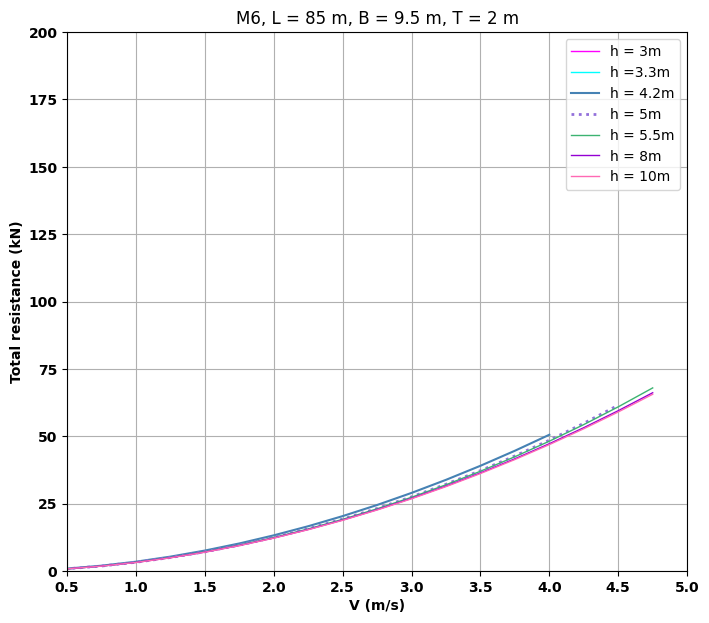

In [8]:
selected_h_3 = plot_df.query('h_more == 3 & V_more <= 3.5')
selected_h_3_2 = plot_df.query('h_more == 3.25 & V_more <= 3.7')
#selected_h_3_5 = plot_df.query('h_more == 3.5 & V_more <= 3.9')
#selected_h_4 = plot_df.query('h_more == 4 & V_more <= 4')
selected_h_4_2 = plot_df.query('h_more == 4.25 & V_more <= 4.2')
selected_h_5 = plot_df.query('h_more == 5 & V_more <= 4.55')
selected_h_5_5= plot_df.query('h_more == 5.5 & V_more <= 4.77')
selected_h_8 = plot_df.query('h_more == 8 & V_more <= 4.9' )
selected_h_10 = plot_df.query('h_more == 10 & V_more <= 4.9')

plt.figure(dpi=300)
plt.figure(figsize=(8,7))
plt.plot(selected_h_3['V_more'],selected_h_3['Rtot'], 'magenta', linewidth = 1.0)
plt.plot(selected_h_3_2['V_more'],selected_h_3_2['Rtot'], 'aqua', linewidth = 1.0)
#plt.plot(selected_h_3_5['V_more'],selected_h_3_5['Pd'], 'skyblue', linewidth = 1.0)
#plt.plot(selected_h_4['V_more'],selected_h_4['Pd'], 'skyblue', linewidth = 1.0)
plt.plot(selected_h_4_2['V_more'],selected_h_4_2['Rtot'], 'steelblue', linewidth = 1.5)
plt.plot(selected_h_5['V_more'],selected_h_5['Rtot'], 'mediumpurple', linewidth = 2.0, linestyle = 'dotted')
plt.plot(selected_h_5_5['V_more'],selected_h_5_5['Rtot'], 'mediumseagreen', linewidth = 1.0)
plt.plot(selected_h_8['V_more'],selected_h_8['Rtot'], 'darkviolet', linewidth = 1)
plt.plot(selected_h_10['V_more'],selected_h_10['Rtot'], 'hotpink', linewidth = 1)


plt.grid()
plt.xlim(0.5,5)
plt.ylim(0,200)
plt.legend(['h = 3m','h =3.3m','h = 4.2m','h = 5m','h = 5.5m','h = 8m','h = 10m'])
plt.xlabel('V (m/s)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Total resistance (kN)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.savefig('Rtot vs velocity original-data-erik.pdf', dpi=100, format='pdf') 
plt.title('M6, L = 85 m, B = 9.5 m, T = 2 m')

Text(0.5, 1.0, 'M6, L = 85 m, B = 9.5 m, T = 2 m')

<Figure size 1920x1440 with 0 Axes>

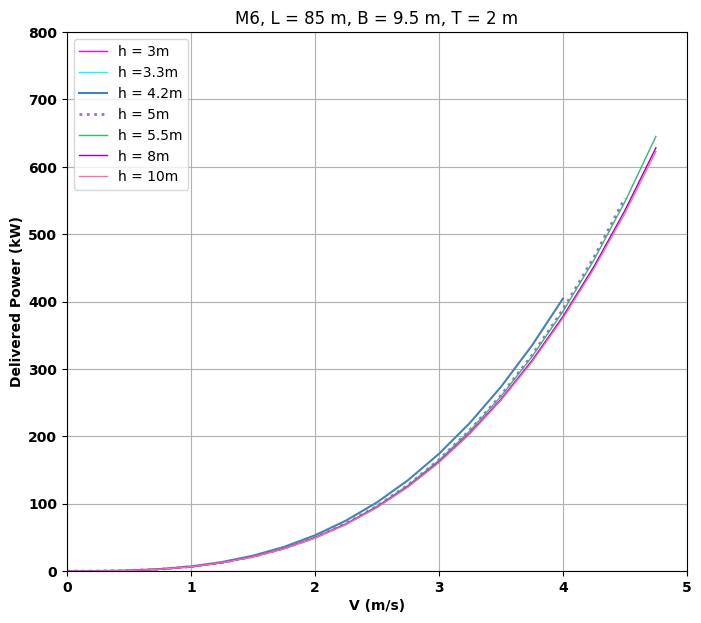

In [9]:
selected_h_3 = plot_df.query('h_more == 3 & V_more <= 3.5')
selected_h_3_2 = plot_df.query('h_more == 3.25 & V_more <= 3.7')
#selected_h_3_5 = plot_df.query('h_more == 3.5 & V_more <= 3.9')
#selected_h_4 = plot_df.query('h_more == 4 & V_more <= 4')
selected_h_4_2 = plot_df.query('h_more == 4.25 & V_more <= 4.2')
selected_h_5 = plot_df.query('h_more == 5 & V_more <= 4.55')
selected_h_5_5= plot_df.query('h_more == 5.5 & V_more <= 4.77')
selected_h_8 = plot_df.query('h_more == 8 & V_more <= 4.9' )
selected_h_10 = plot_df.query('h_more == 10 & V_more <= 4.9')

plt.figure(dpi=300)
plt.figure(figsize=(8,7))
plt.plot(selected_h_3['V_more'],selected_h_3['Pd'], 'magenta', linewidth = 1.0)
plt.plot(selected_h_3_2['V_more'],selected_h_3_2['Pd'], 'aqua', linewidth = 1.0)
#plt.plot(selected_h_3_5['V_more'],selected_h_3_5['Pd'], 'skyblue', linewidth = 1.0)
#plt.plot(selected_h_4['V_more'],selected_h_4['Pd'], 'skyblue', linewidth = 1.0)
plt.plot(selected_h_4_2['V_more'],selected_h_4_2['Pd'], 'steelblue', linewidth = 1.5)
plt.plot(selected_h_5['V_more'],selected_h_5['Pd'], 'mediumpurple', linewidth = 2.0, linestyle = 'dotted')
plt.plot(selected_h_5_5['V_more'],selected_h_5_5['Pd'], 'mediumseagreen', linewidth = 1.0)
plt.plot(selected_h_8['V_more'],selected_h_8['Pd'], 'darkviolet', linewidth = 1)
plt.plot(selected_h_10['V_more'],selected_h_10['Pd'], 'hotpink', linewidth = 1)


plt.grid()
plt.xlim(0,5)
plt.ylim(0,800)
plt.legend(['h = 3m','h =3.3m','h = 4.2m','h = 5m','h = 5.5m','h = 8m','h = 10m'])
plt.xlabel('V (m/s)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Delivered Power (kW)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.savefig('Pd vs velocity original-data-erik.pdf', dpi=100, format='pdf') 
plt.title('M6, L = 85 m, B = 9.5 m, T = 2 m')

Text(0.5, 1.0, 'M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 50m')

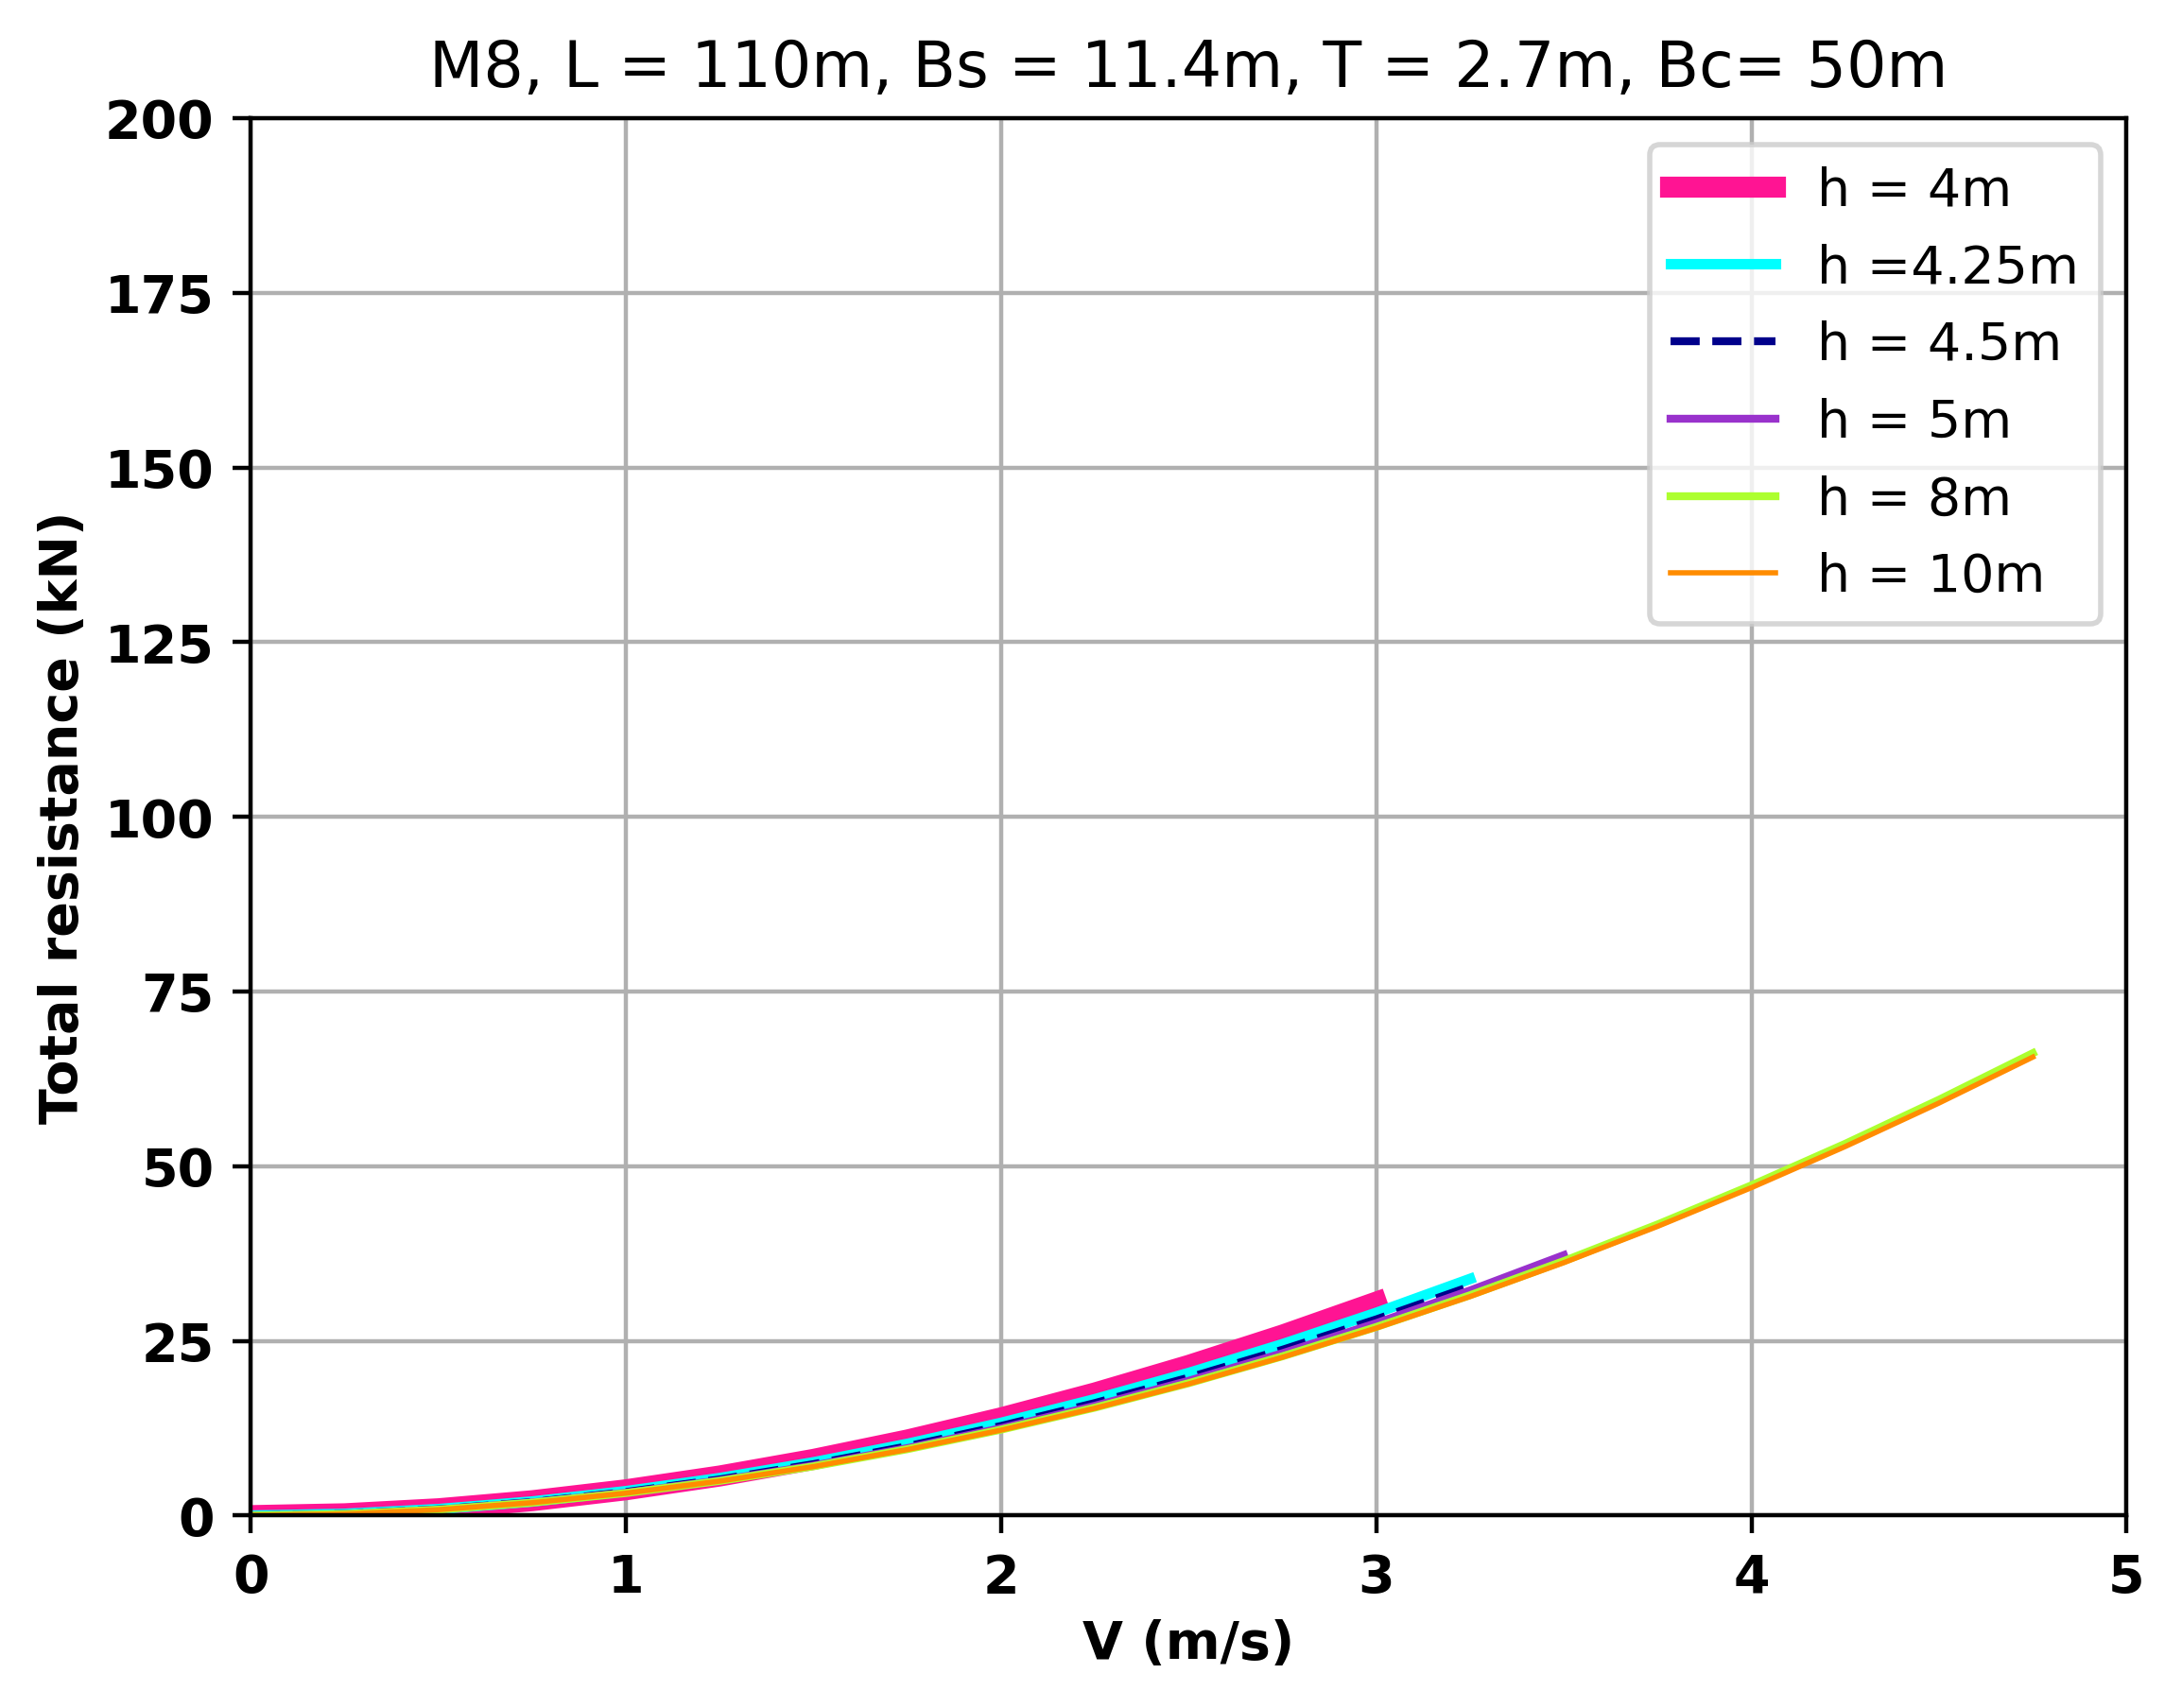

In [10]:
selected_h_4 = plot_df.query('h_more == 4 & V_more <= 3')
selected_h_4_2 = plot_df.query('h_more == 4.25 & V_more <= 3.25')
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3.3')
selected_h_5 = plot_df.query('h_more == 5 & V_more <= 3.5')
selected_h_8 = plot_df.query('h_more == 8 & V_more <= 4.8')
selected_h_10 = plot_df.query('h_more == 10 & V_more <= 4.8')

plt.figure(dpi=400)
plt.plot(selected_h_4['V_more'],selected_h_4['Rtot'], 'deeppink', linewidth = 4)
plt.plot(selected_h_4_2['V_more'],selected_h_4_2['Rtot'], 'cyan', linewidth = 2)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Rtot'], 'darkblue', linewidth = 1.5, linestyle = 'dashed')
plt.plot(selected_h_5['V_more'],selected_h_5['Rtot'], 'darkorchid', linewidth = 1.5)
plt.plot(selected_h_8['V_more'],selected_h_8['Rtot'], 'greenyellow', linewidth = 1.5)
plt.plot(selected_h_10['V_more'],selected_h_10['Rtot'], 'darkorange', linewidth = 1)

plt.grid()
plt.xlim(0,5)
plt.ylim(0,200)
plt.legend(['h = 4m','h =4.25m','h = 4.5m','h = 5m','h = 8m','h = 10m'])
plt.xlabel('V (m/s)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Total resistance (kN)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.savefig('M8-Erik Rtot-Vs.pdf',dpi=600, format='pdf')
plt.title('M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 50m')

Text(0.5, 1.0, 'M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 50m')

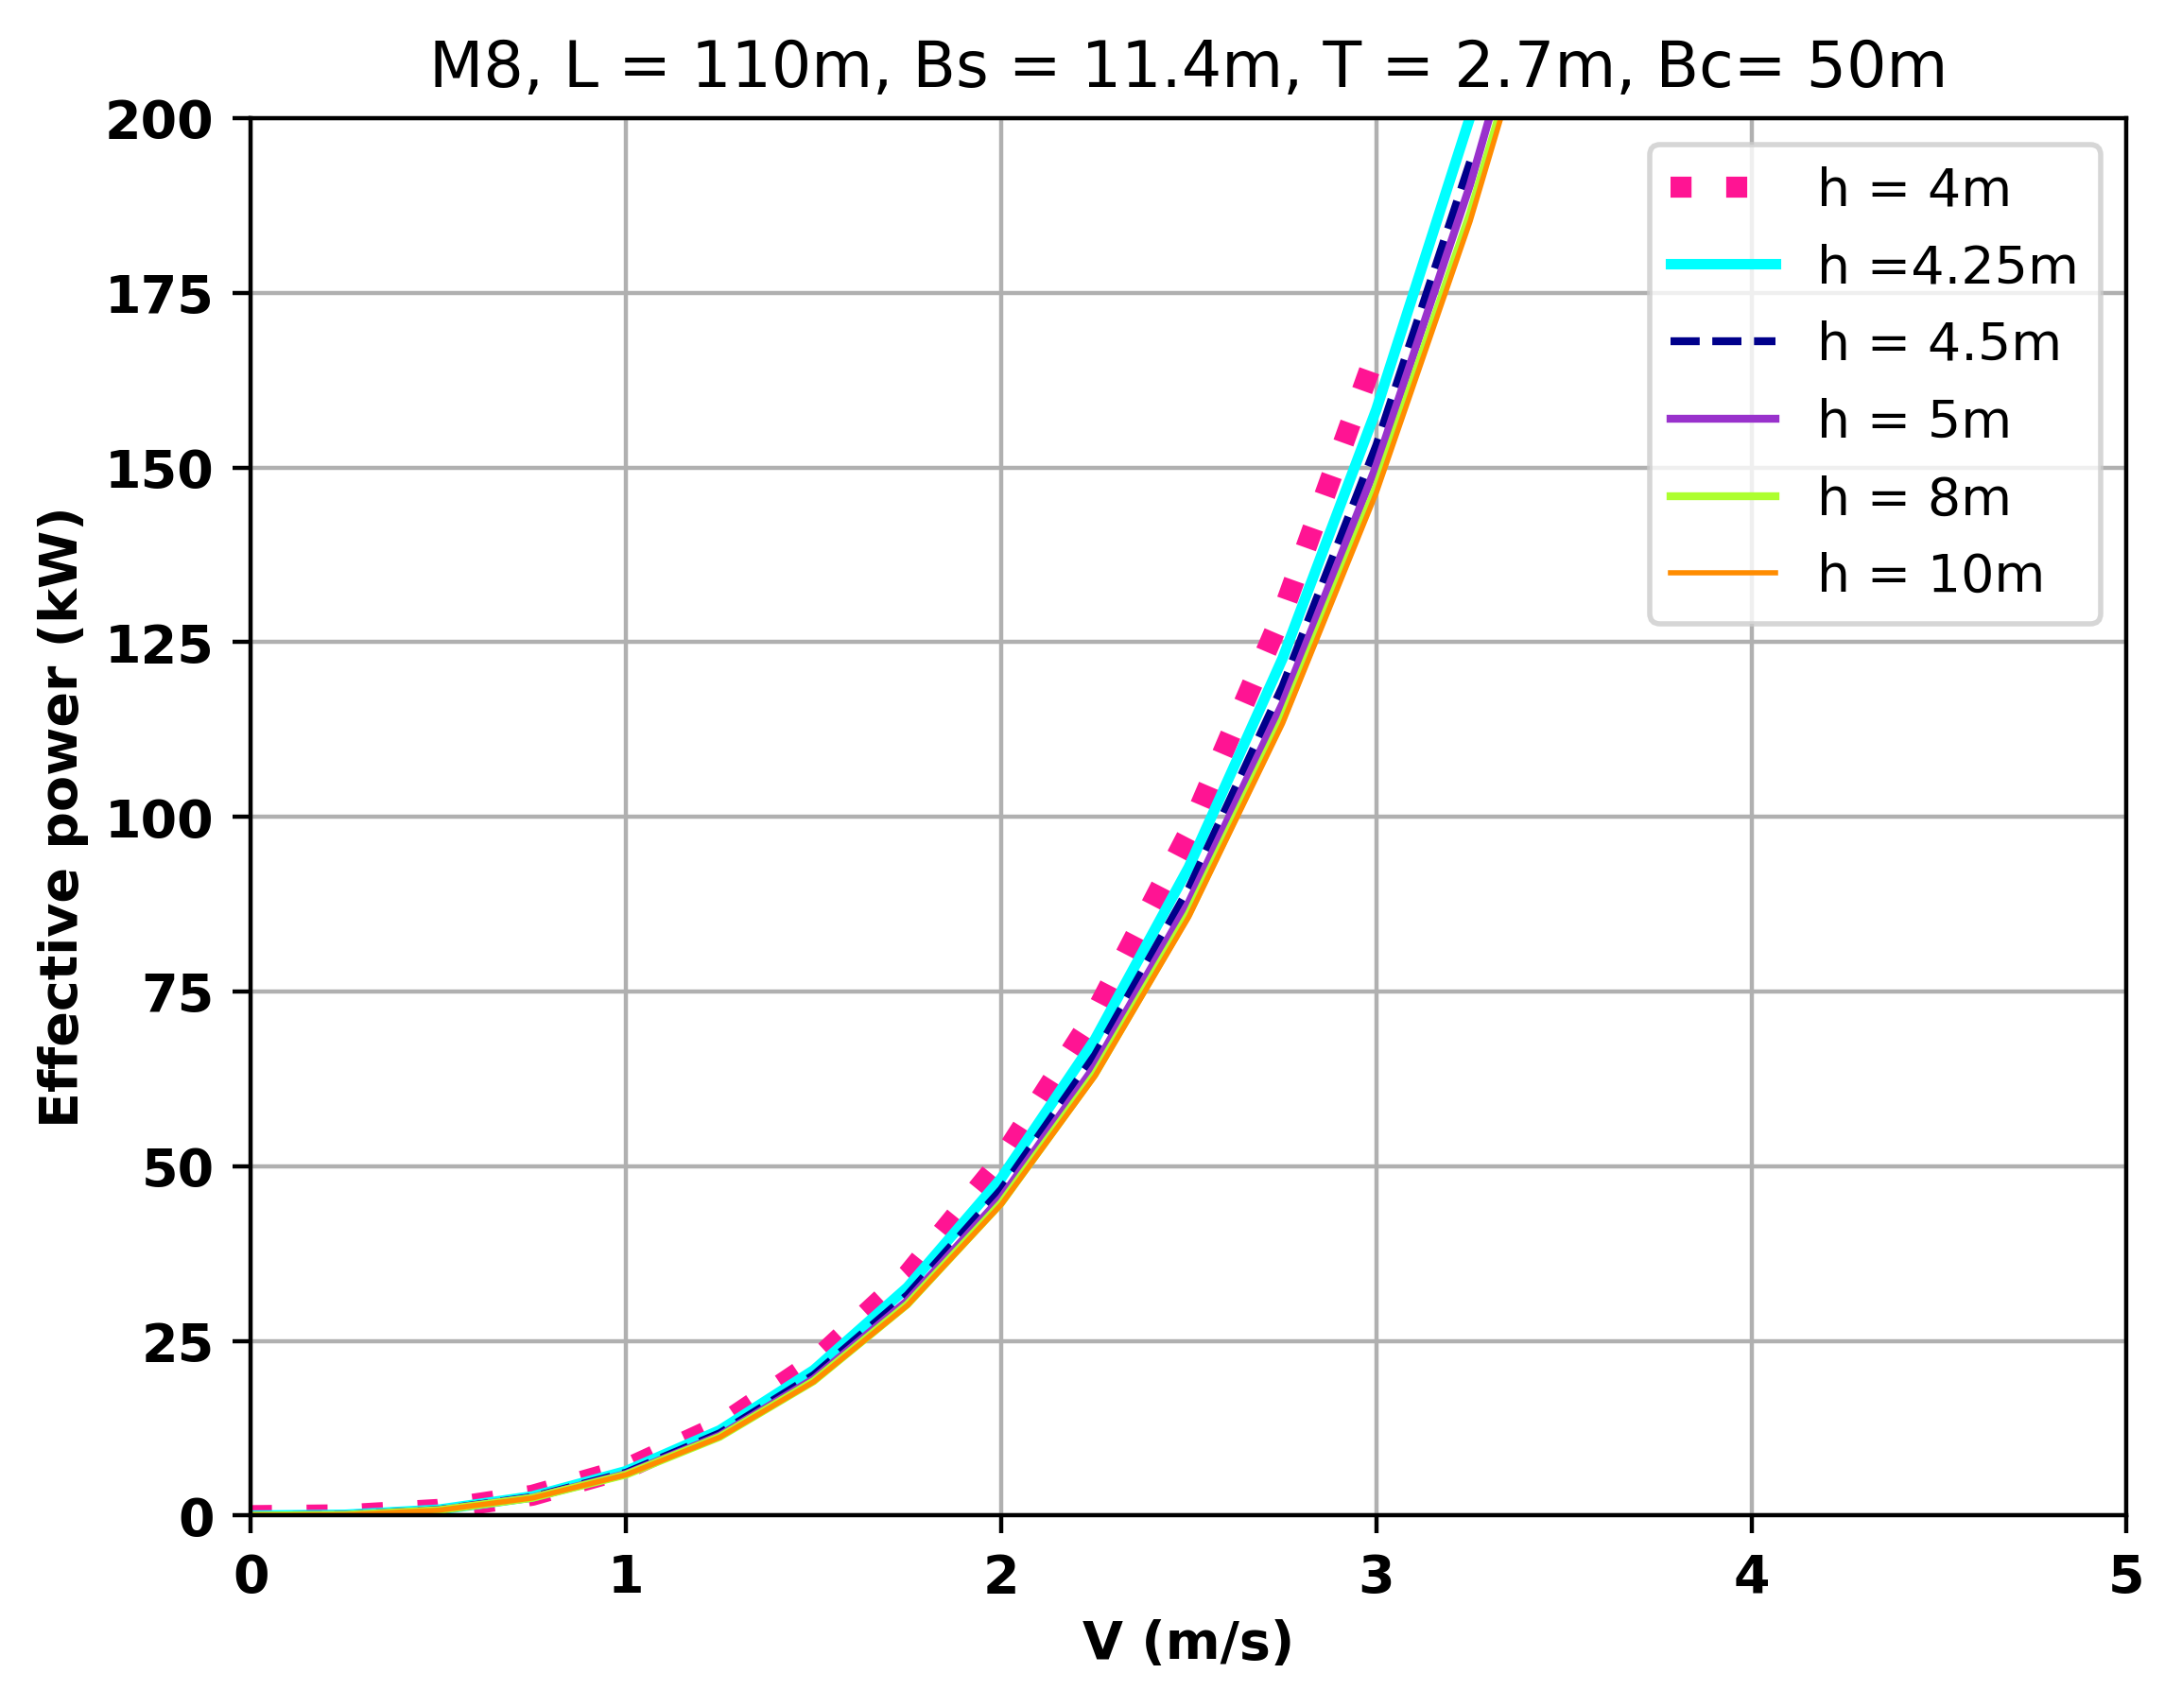

In [11]:
selected_h_4 = plot_df.query('h_more == 4 & V_more <= 3')
selected_h_4_2 = plot_df.query('h_more == 4.25 & V_more <= 3.25')
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3.3')
selected_h_5 = plot_df.query('h_more == 5 & V_more <= 3.5')
selected_h_8 = plot_df.query('h_more == 8 & V_more <= 4.8')
selected_h_10 = plot_df.query('h_more == 10 & V_more <= 4.8')

plt.figure(dpi=400)
plt.plot(selected_h_4['V_more'],selected_h_4['Pe'], 'deeppink', linewidth = 4, linestyle = 'dotted')
plt.plot(selected_h_4_2['V_more'],selected_h_4_2['Pe'], 'cyan', linewidth = 2)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Pe'], 'darkblue', linewidth = 1.5, linestyle = 'dashed')
plt.plot(selected_h_5['V_more'],selected_h_5['Pe'], 'darkorchid', linewidth = 1.5)
plt.plot(selected_h_8['V_more'],selected_h_8['Pe'], 'greenyellow', linewidth = 1.5)
plt.plot(selected_h_10['V_more'],selected_h_10['Pe'], 'darkorange', linewidth = 1)

plt.grid()
plt.xlim(0,5)
plt.ylim(0,200)
plt.legend(['h = 4m','h =4.25m','h = 4.5m','h = 5m','h = 8m','h = 10m'])
plt.xlabel('V (m/s)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Effective power (kW)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.savefig('M8-Erik Pe-Vs.pdf',dpi=600, format='pdf')
plt.title('M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 50m')

Text(0.5, 1.0, 'M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 50m')

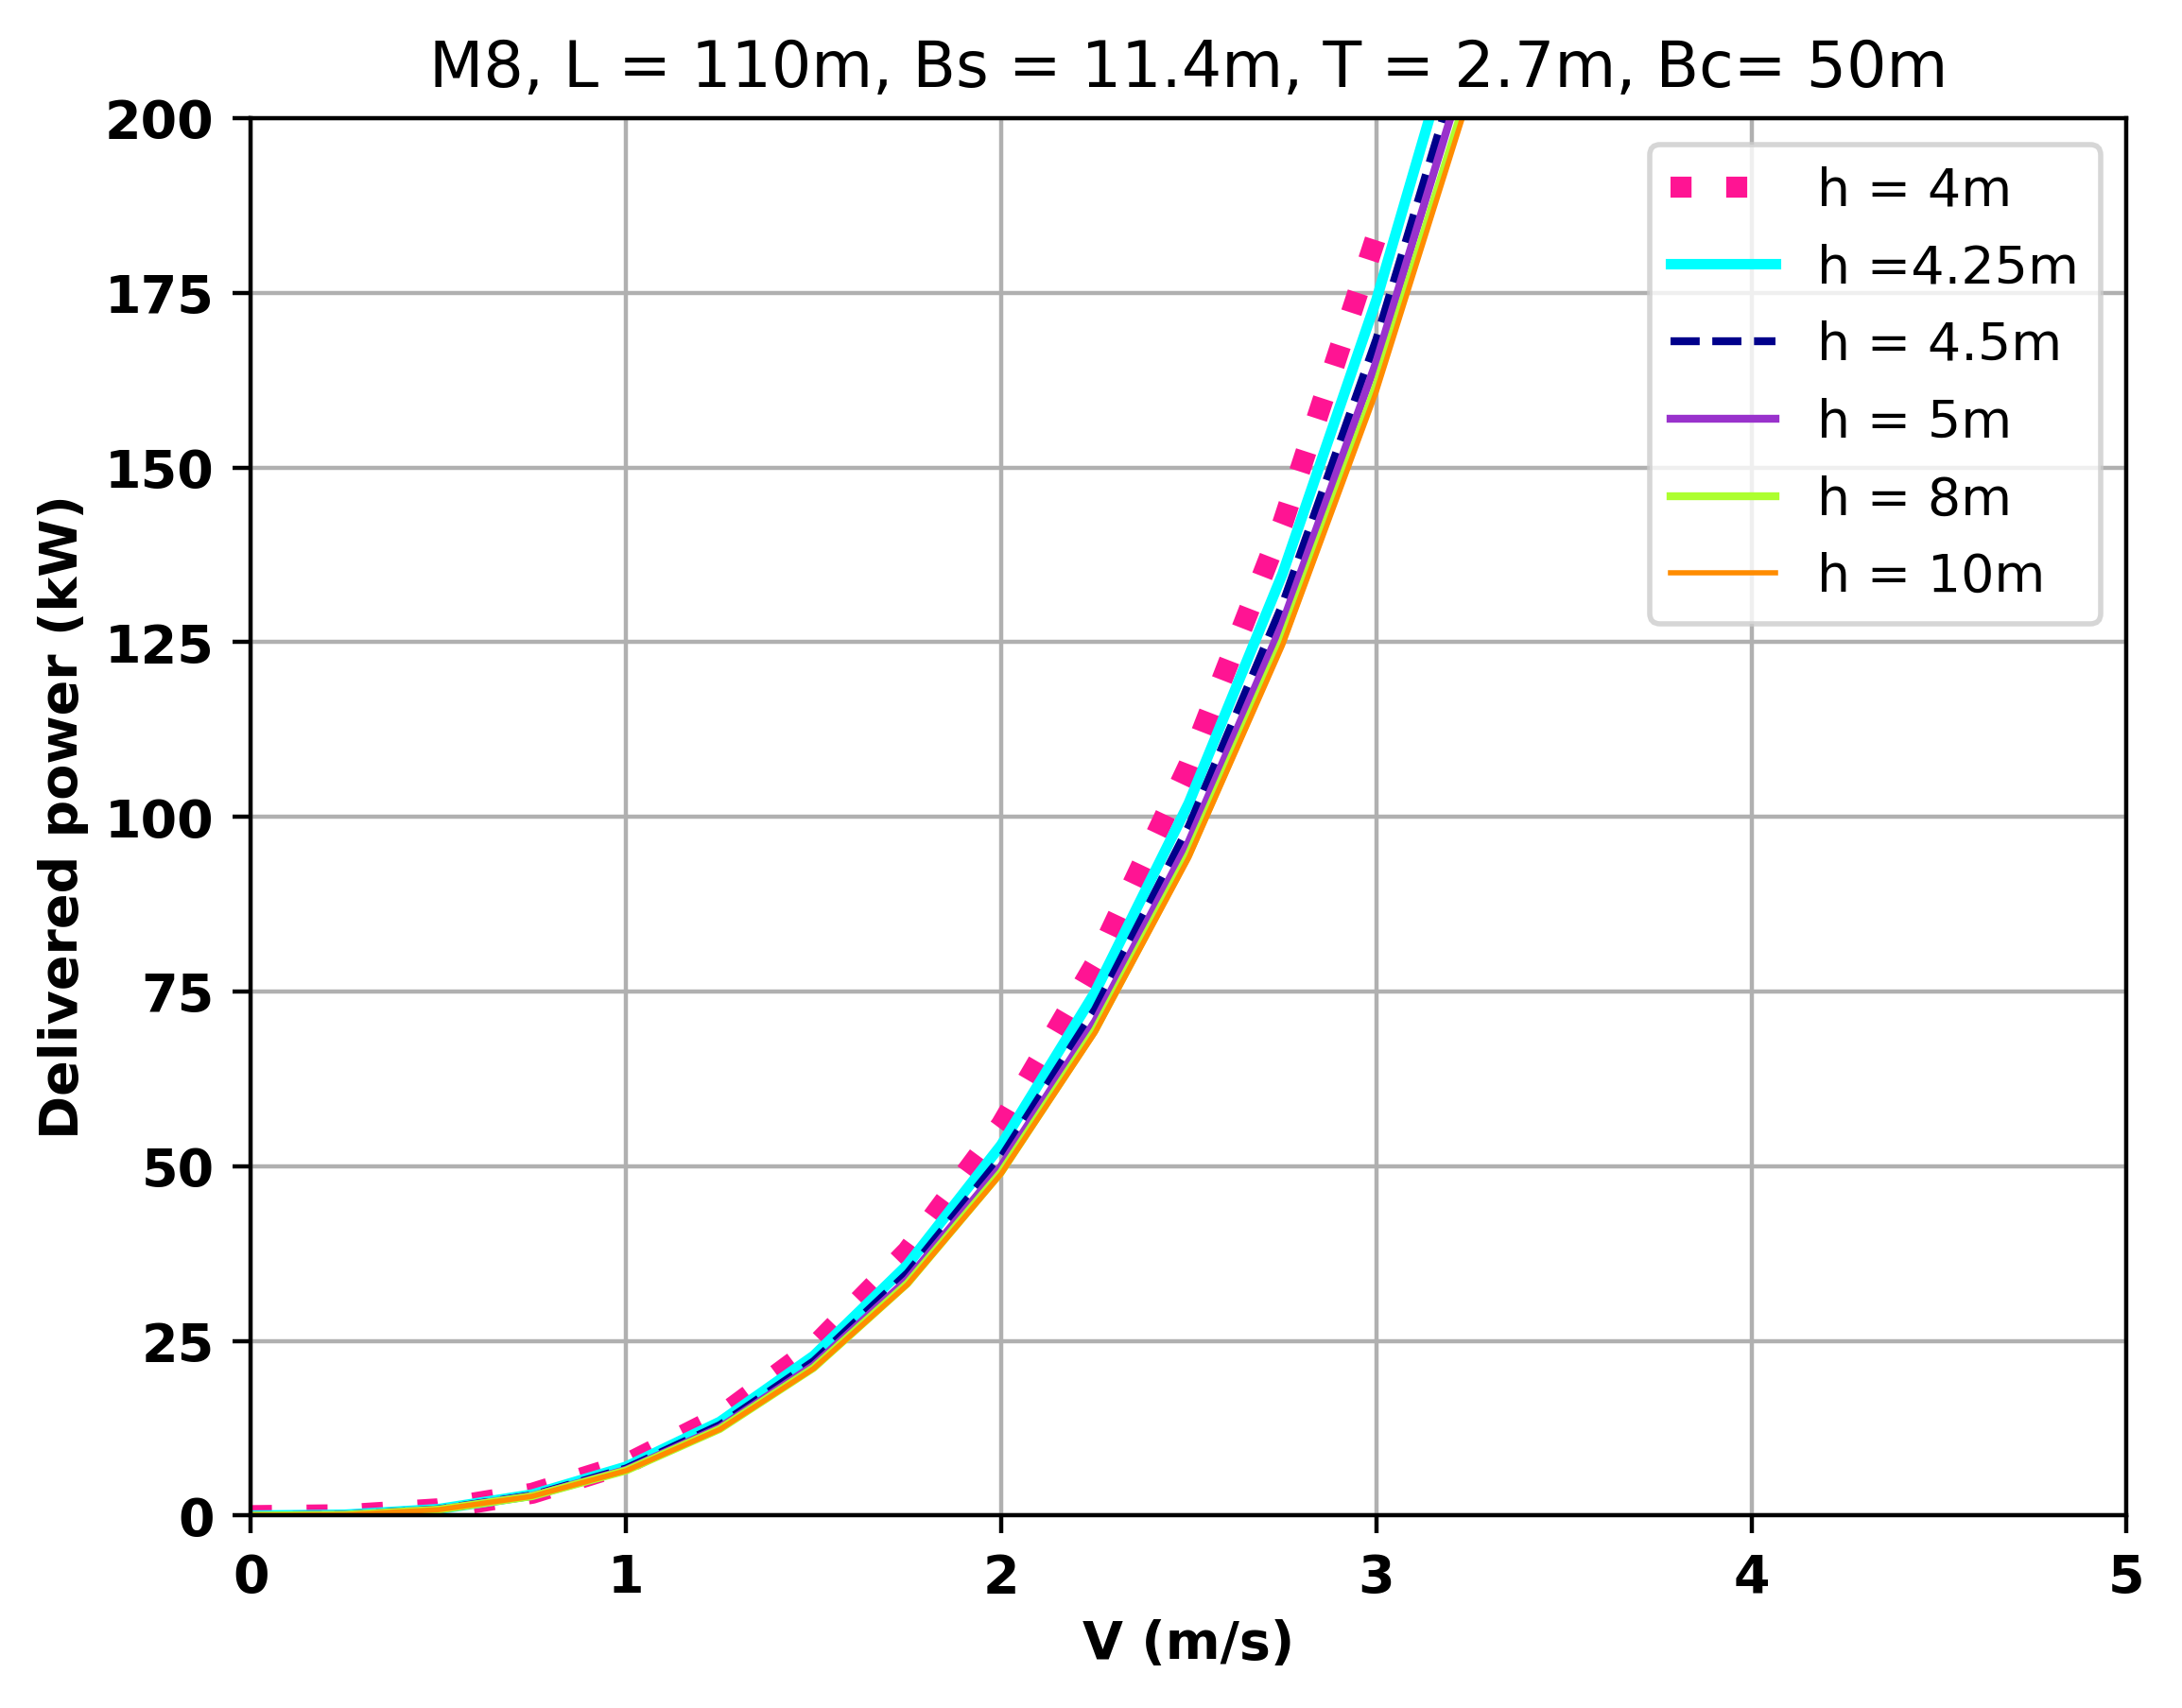

In [12]:
selected_h_4 = plot_df.query('h_more == 4 & V_more <= 3')
selected_h_4_2 = plot_df.query('h_more == 4.25 & V_more <= 3.25')
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3.3')
selected_h_5 = plot_df.query('h_more == 5 & V_more <= 3.5')
selected_h_8 = plot_df.query('h_more == 8 & V_more <= 4.8')
selected_h_10 = plot_df.query('h_more == 10 & V_more <= 4.8')

plt.figure(dpi=400)
plt.plot(selected_h_4['V_more'],selected_h_4['Pd'], 'deeppink', linewidth = 4, linestyle = 'dotted')
plt.plot(selected_h_4_2['V_more'],selected_h_4_2['Pd'], 'cyan', linewidth = 2)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Pd'], 'darkblue', linewidth = 1.5, linestyle = 'dashed')
plt.plot(selected_h_5['V_more'],selected_h_5['Pd'], 'darkorchid', linewidth = 1.5)
plt.plot(selected_h_8['V_more'],selected_h_8['Pd'], 'greenyellow', linewidth = 1.5)
plt.plot(selected_h_10['V_more'],selected_h_10['Pd'], 'darkorange', linewidth = 1)

plt.grid()
plt.xlim(0,5)
plt.ylim(0,200)
plt.legend(['h = 4m','h =4.25m','h = 4.5m','h = 5m','h = 8m','h = 10m'])
plt.xlabel('V (m/s)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Delivered power (kW)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.savefig('M8-Erik Pd-Vs.pdf',dpi=600, format='pdf')
plt.title('M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 50m')

Text(0.5, 1.0, 'M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 150m')

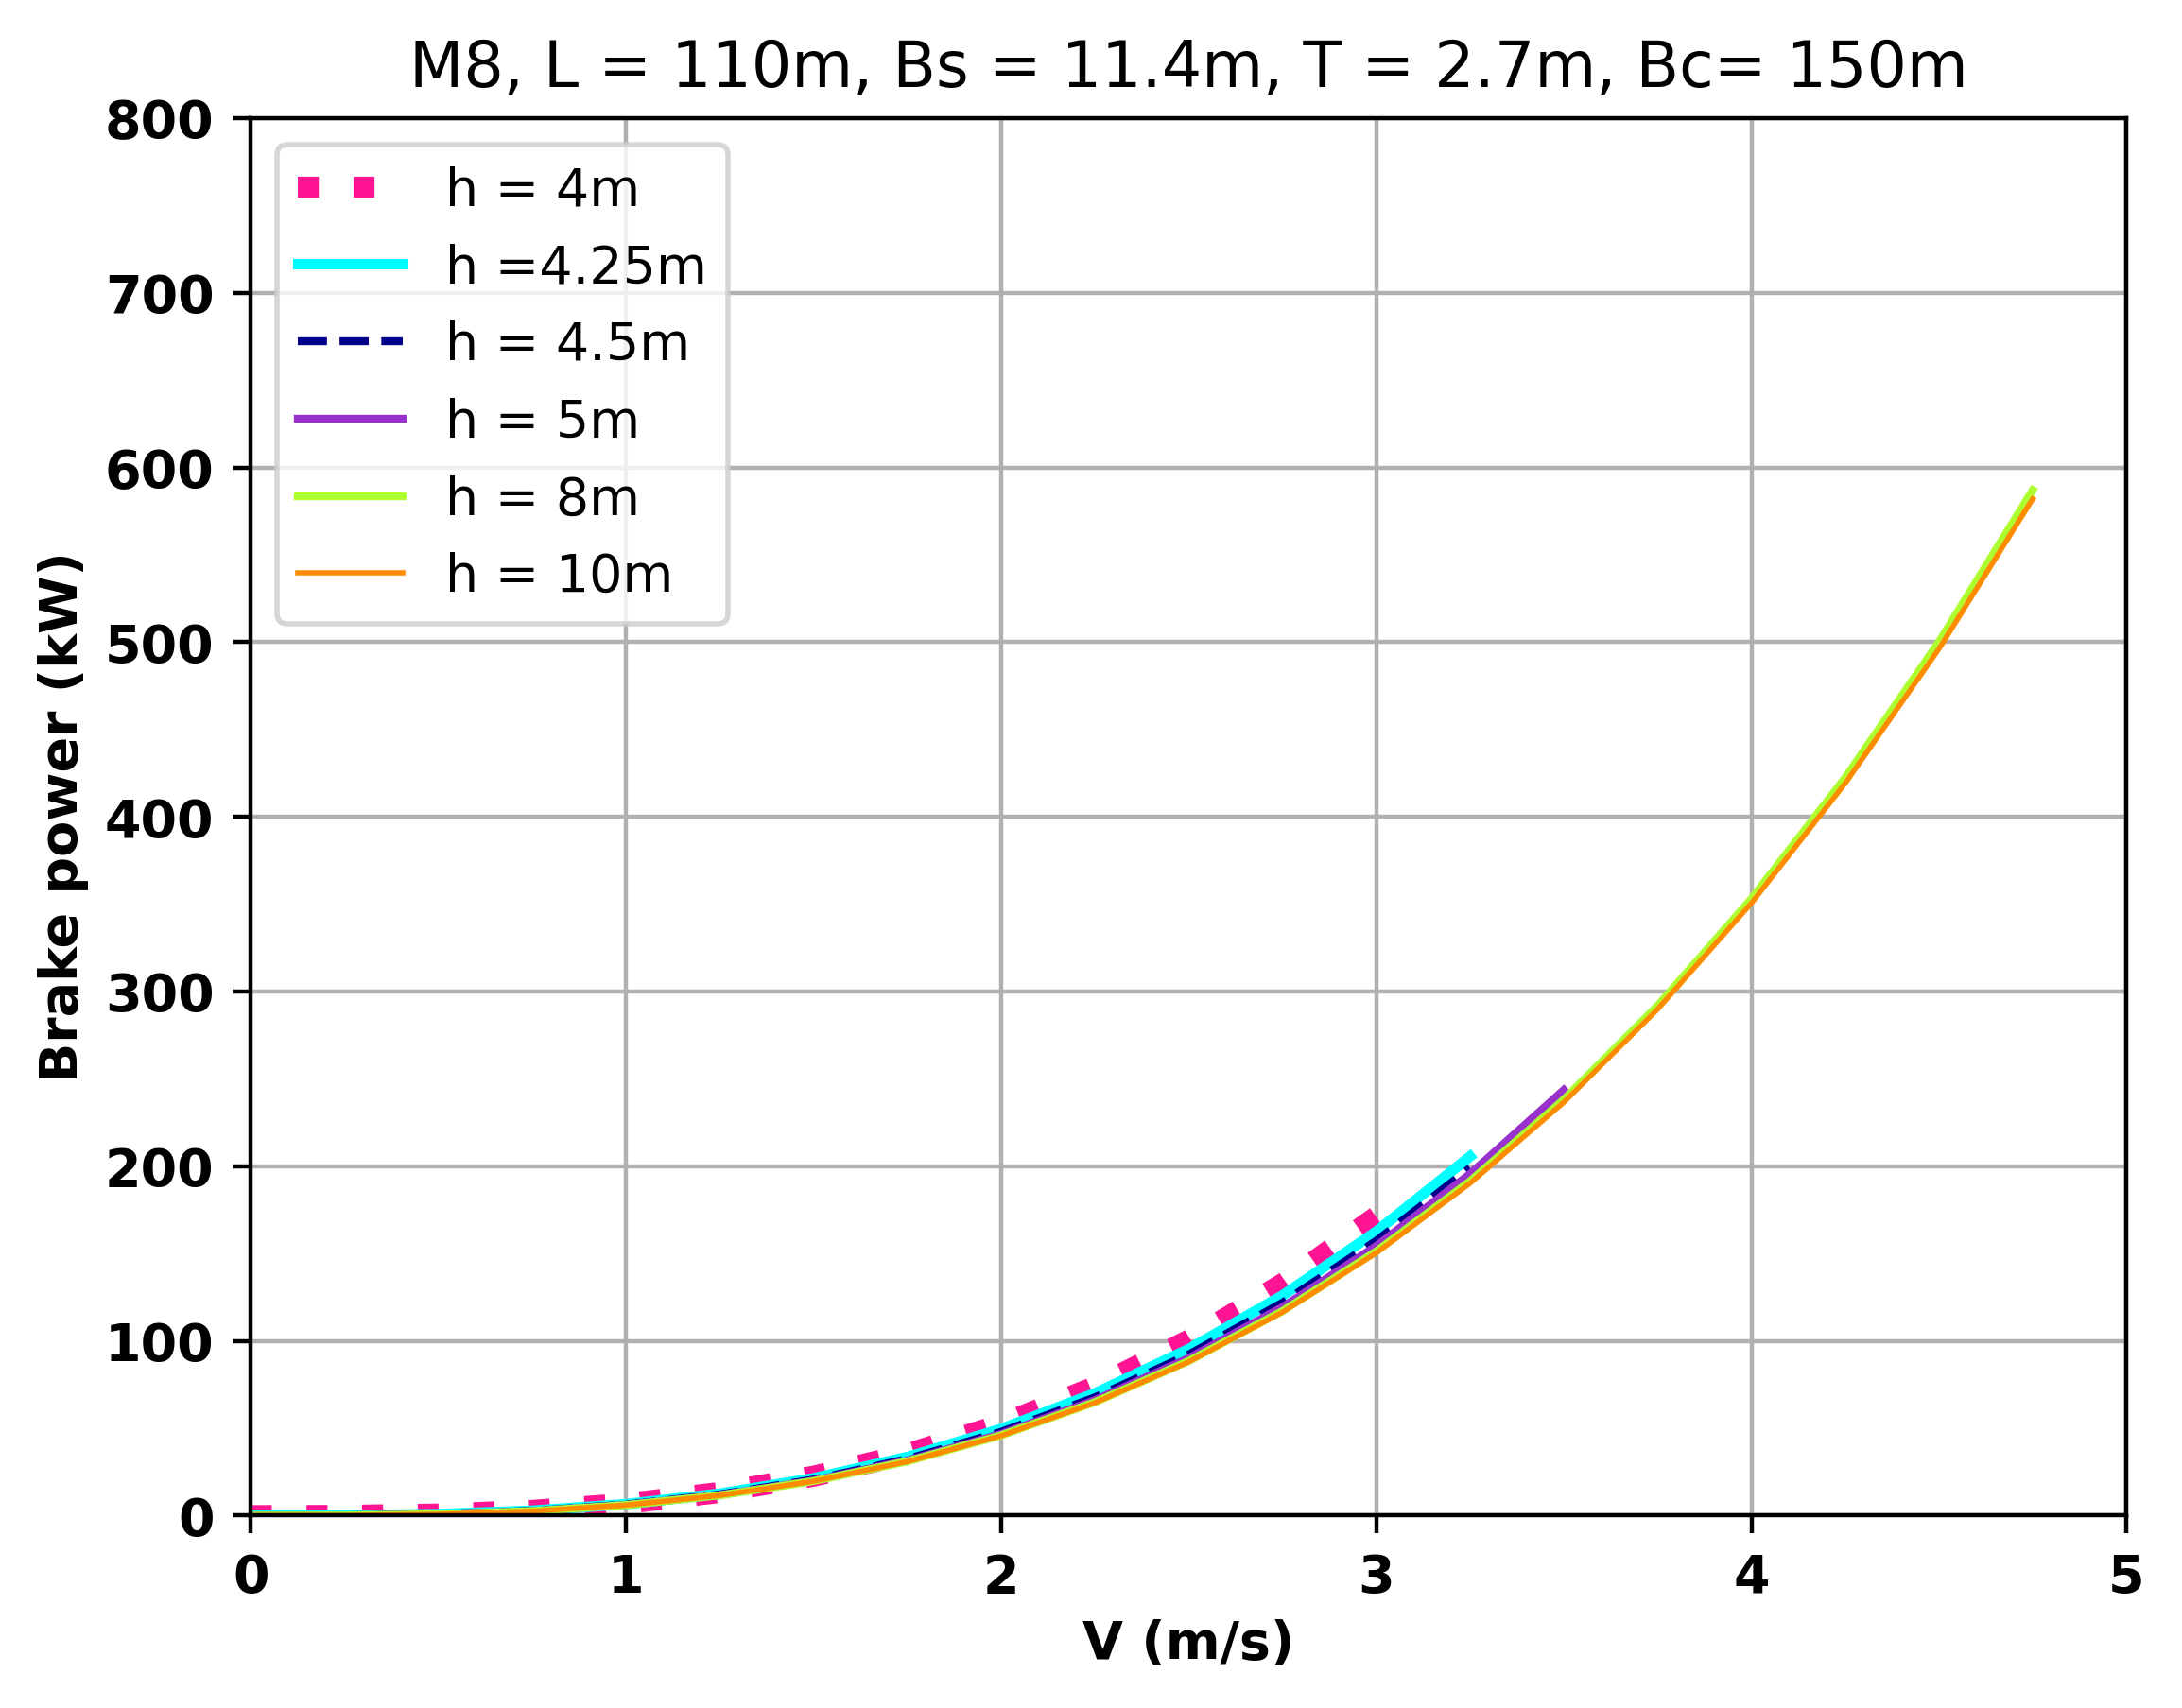

In [13]:
selected_h_4 = plot_df.query('h_more == 4 & V_more <= 3')
selected_h_4_2 = plot_df.query('h_more == 4.25 & V_more <= 3.25')
selected_h_4_5 = plot_df.query('h_more == 4.5 & V_more <= 3.3')
selected_h_5 = plot_df.query('h_more == 5 & V_more <= 3.5')
selected_h_8 = plot_df.query('h_more == 8 & V_more <= 4.8')
selected_h_10 = plot_df.query('h_more == 10 & V_more <= 4.8')
plt.figure(dpi=400)
plt.plot(selected_h_4['V_more'],selected_h_4['Pb'], 'deeppink', linewidth = 4, linestyle = 'dotted')
plt.plot(selected_h_4_2['V_more'],selected_h_4_2['Pb'], 'cyan', linewidth = 2)
plt.plot(selected_h_4_5['V_more'],selected_h_4_5['Pb'], 'darkblue', linewidth = 1.5, linestyle = 'dashed')
plt.plot(selected_h_5['V_more'],selected_h_5['Pb'], 'darkorchid', linewidth = 1.5)
plt.plot(selected_h_8['V_more'],selected_h_8['Pb'], 'greenyellow', linewidth = 1.5)
plt.plot(selected_h_10['V_more'],selected_h_10['Pb'], 'darkorange', linewidth = 1)

plt.grid()
plt.xlim(0,5)
plt.ylim(0,800)
plt.legend(['h = 4m','h =4.25m','h = 4.5m','h = 5m','h = 8m','h = 10m'])
plt.xlabel('V (m/s)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Brake power (kW)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.savefig('w-M8-Erik Pb-Vs.pdf',dpi=600, format='pdf')
plt.title('M8, L = 110m, Bs = 11.4m, T = 2.7m, Bc= 150m')

Text(0.5, 1.0, 'M8, L = 85 m, B = 9.5 m, T = 2 m')

<Figure size 1920x1440 with 0 Axes>

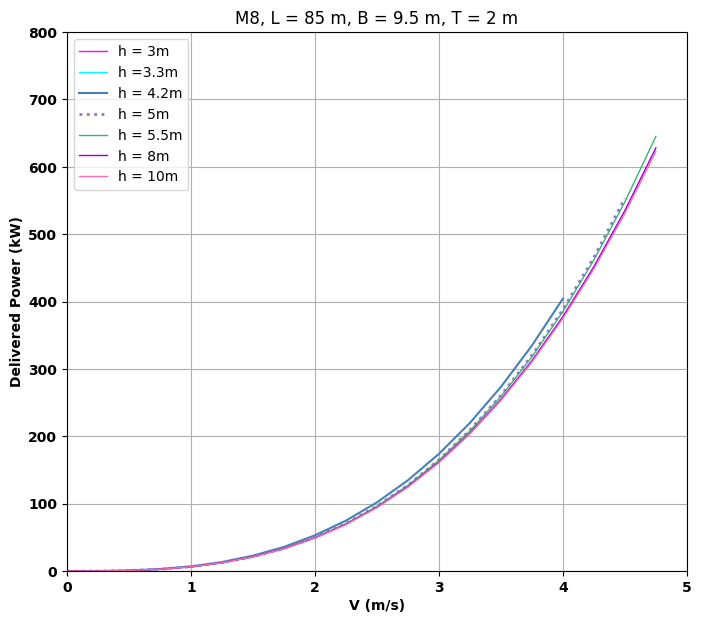

In [14]:
selected_h_3 = plot_df.query('h_more == 3 & V_more <= 3.5')
selected_h_3_2 = plot_df.query('h_more == 3.25 & V_more <= 3.7')
#selected_h_3_5 = plot_df.query('h_more == 3.5 & V_more <= 3.9')
#selected_h_4 = plot_df.query('h_more == 4 & V_more <= 4')
selected_h_4_2 = plot_df.query('h_more == 4.25 & V_more <= 4.2')
selected_h_5 = plot_df.query('h_more == 5 & V_more <= 4.55')
selected_h_5_5= plot_df.query('h_more == 5.5 & V_more <= 4.77')
selected_h_8 = plot_df.query('h_more == 8 & V_more <= 4.9' )
selected_h_10 = plot_df.query('h_more == 10 & V_more <= 4.9')

plt.figure(dpi=300)
plt.figure(figsize=(8,7))
plt.plot(selected_h_3['V_more'],selected_h_3['Pd'], 'magenta', linewidth = 1.0)
plt.plot(selected_h_3_2['V_more'],selected_h_3_2['Pd'], 'aqua', linewidth = 1.0)
#plt.plot(selected_h_3_5['V_more'],selected_h_3_5['Pd'], 'skyblue', linewidth = 1.0)
#plt.plot(selected_h_4['V_more'],selected_h_4['Pd'], 'skyblue', linewidth = 1.0)
plt.plot(selected_h_4_2['V_more'],selected_h_4_2['Pd'], 'steelblue', linewidth = 1.5)
plt.plot(selected_h_5['V_more'],selected_h_5['Pd'], 'mediumpurple', linewidth = 2.0, linestyle = 'dotted')
plt.plot(selected_h_5_5['V_more'],selected_h_5_5['Pd'], 'mediumseagreen', linewidth = 1.0)
plt.plot(selected_h_8['V_more'],selected_h_8['Pd'], 'darkviolet', linewidth = 1)
plt.plot(selected_h_10['V_more'],selected_h_10['Pd'], 'hotpink', linewidth = 1)


plt.grid()
plt.xlim(0,5)
plt.ylim(0,800)
plt.legend(['h = 3m','h =3.3m','h = 4.2m','h = 5m','h = 5.5m','h = 8m','h = 10m'])
plt.xlabel('V (m/s)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Delivered Power (kW)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.savefig('Erik Pd vs velocity original-data.pdf', dpi=100, format='pdf') 
plt.title('M8, L = 85 m, B = 9.5 m, T = 2 m')